In [1]:
import json
from pathlib import Path
from uuid import UUID

import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.wkb

In [2]:
# plotting settings
DATAROOT = Path("../data")
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "text.usetex": True,
    }
)

In [3]:
def read_river_network(filepath: Path):
    rivers: dict[UUID, shapely.LineString] = {}
    downstreams: dict[UUID, UUID | None] = {}
    river_index: dict[int, UUID] = {}
    river_to_index: dict[UUID, int] = {}
    with open(filepath, "r") as f:
        for line in f:
            feature = json.loads(line)
            rid = UUID(feature["properties"]["uuid"])
            river_index[int(feature["properties"]["linkid"])] = rid
            river_to_index[rid] = int(feature["properties"]["to"] or -1)
            geom = shapely.geometry.shape(feature["geometry"])
            rivers[rid] = geom
    for rid, to in river_to_index.items():
        if to != -1:
            downstreams[rid] = river_index[to]
        else:
            downstreams[rid] = None
    return rivers, downstreams


rivers, downstreams = read_river_network(DATAROOT.joinpath("river_network.geojsonl"))

In [4]:
with h5netcdf.File("../data/setup.nc", "r") as f:
    lat = np.array(f.variables["south_north"][:], np.float64)
    lon = np.array(f.variables["west_east"][:], np.float64)
    hgt = np.array(f.variables["HGT"][:], np.float32)
    mask = np.array(f.variables["XLAND"][:] == 1, np.bool)

In [5]:
with h5netcdf.File("../data/inbasin.nc", "r") as f:
    inbasin = np.array(f.variables["inbasin"][:], np.bool)

In [6]:
station: dict[UUID, tuple[float, float]] = {}
with open("../data/station.csv", "rt") as f:
    next(f)
    for line in f:
        sid, _name, _merit, _rid, lat_, lon_ = line.strip().split(",")
        station[UUID(sid)] = (float(lat_), float(lon_))

station_pinyin = {
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"): "ZMD",
    UUID("urn:uuid:AC5B1300-C6EE-4395-A285-D77C6B3A1C95"): "BT",
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"): "GT",
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"): "BZL",
}

selected_stations = [
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"),
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"),
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"),
    # UUID("urn:uuid:AC5B1300-C6EE-4395-A285-D77C6B3A1C95"),
]

In [7]:
def plot_ucj(ax):
    ax.set_aspect("equal")
    ax.set_xlim(90.49, 100.22)
    ax.set_ylim(28.10, 35.83)
    ax.set_xticks(np.arange(92, 100.1, 2))
    ax.set_xticklabels([f"{x:.0f}°E" for x in np.arange(92, 100.1, 2)])
    ax.set_yticks(np.arange(29.0, 36, 1))
    ax.set_yticklabels([f"{x:.0f}°N" for x in np.arange(29.0, 36, 1)])


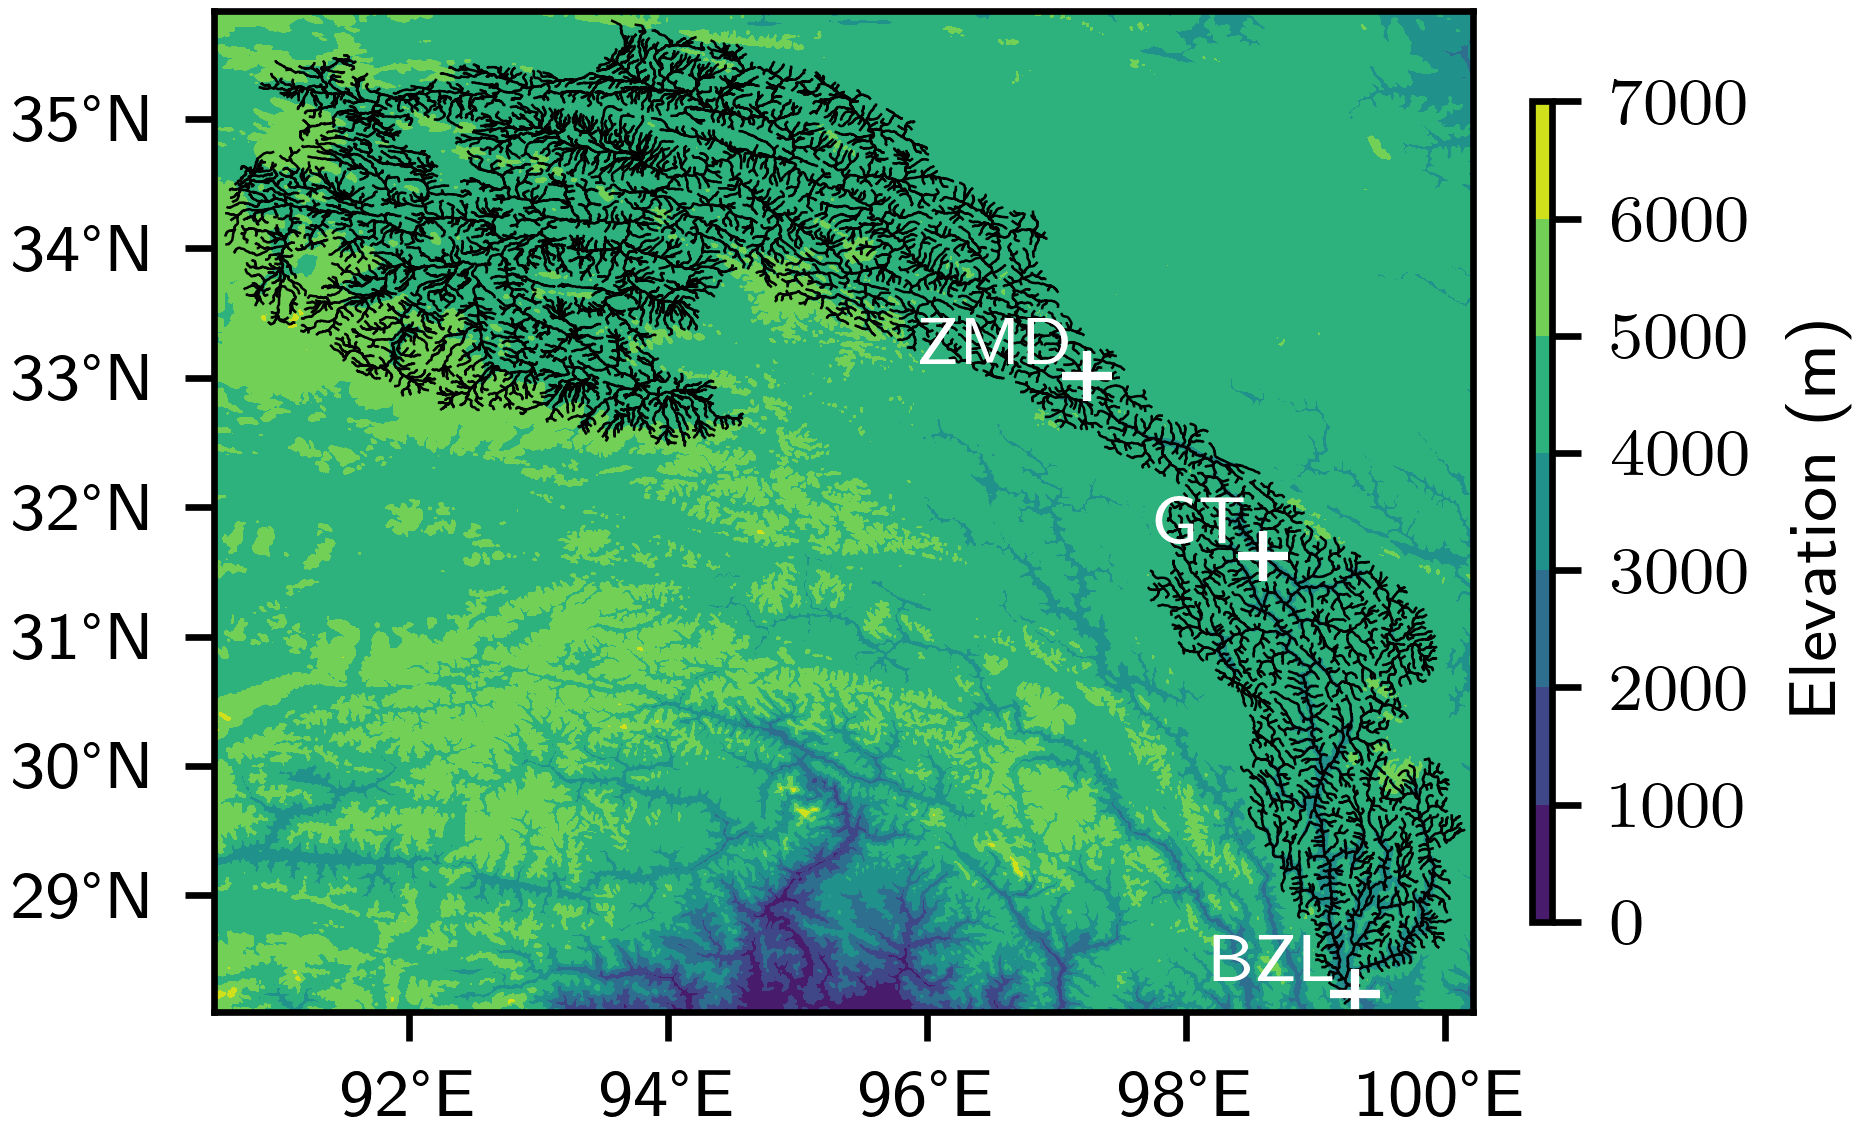

In [8]:
fig = plt.figure(figsize=(8 / 2.54, 6 / 2.54), dpi=FIGDPI, layout="constrained")
ax = fig.add_subplot(111)

cf = ax.contourf(lon, lat, hgt)

for ll in rivers.values():
    ax.plot(*ll.xy, color="black", linewidth=0.3)

for sid in selected_stations:
    lat_, lon_ = station[sid]
    ax.plot(lon_, lat_, "+", color="white", markersize=6)
    ax.text(
        lon_ - 0.1,
        lat_,
        station_pinyin[sid],
        color="white",
        fontsize=8,
        ha="right",
        va="bottom",
    )

plot_ucj(ax)
plt.colorbar(cf, ax=ax, label="Elevation (m)", shrink=0.6, pad=0.001, aspect=40)

fig.savefig(FIGROOT.joinpath("domain").with_suffix(FIGSUFFIX), bbox_inches="tight")

In [9]:
with h5netcdf.File("../data/inbasin.nc", "r") as f:
    inbasin = np.array(f.variables["inbasin"][:], np.bool)

In [10]:
np.nanmax(hgt[inbasin]), np.nanmin(hgt[inbasin])

(np.float32(6229.264), np.float32(2140.7705))